<span style="font-family: Algerian; font-size:2.40em;color:DarkBlue;"> COVID-19- Dashboard for Twitter Sentiment Analysis  

## What is COVID-19?

> <span style="font-family: constantia; font-size:1.40em;color:black;"> Coronaviruses are a large family of viruses that may cause respiratory illnesses in humans ranging from common colds to more severe conditions such as Severe Acute Respiratory Syndrome (SARS) and Middle Eastern Respiratory Syndrome (MERS).<br>
'Novel coronavirus' is a new, previously unidentified strain of coronavirus. The novel coronavirus involved in the current outbreak has been named SARS-CoV-2 by the World Health Organization (WHO). The disease it causes has been named “coronavirus disease 2019” (or “COVID-19”).`

In [73]:
# !pip install GetOldTweets3
import pandas as pd
import numpy as np
import re
from pprint import pprint
from datetime import datetime

#scraping
import GetOldTweets3 as got
import time

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from ipywidgets import interact, interact_manual


In [74]:
def get_tweets(text_query, start_date, end_date, lang, location, within):
   
    # specifying tweet search criteria 
    tweetCriteria = got.manager.TweetCriteria().setQuerySearch(text_query)\
                          .setSince(start_date)\
                          .setUntil(end_date)\
                          .setLang(lang)\
                          .setNear(location)\
                          .setWithin(within)
    
    # scraping tweets based on criteria
    tweet = got.manager.TweetManager.getTweets(tweetCriteria)
    
    # creating list of tweets with the tweet attributes 
    # specified in the list comprehension
    text_tweets = [[tw.username,
                tw.text,
                tw.date,
                tw.retweets,
                tw.favorites,
                tw.hashtags] for tw in tweet]
    
    # creating dataframe, assigning column names to list of
    # tweets corresponding to tweet attributes
    tw_df = pd.DataFrame(text_tweets, 
                         columns = ['User', 'Text', 'Date', 'Retweets', 'Favorites', 'HashTags'])
    
    return tw_df

## Twitter data collected from 10 different countries related to COVID Hashtag

In [75]:
# set attributes needed for get_tweets
text_query = '#COVID '
start_date = '2020-04-15'
end_date = '2020-05-31'
lang = 'en'
within = '50mi'

citys = ['India, Pune', 'New York City, New York','Boston, Massachusetts','Chicago, Illinois','Detroit, Michigan','Los Angeles, California','Houston, Texas','Newark, New Jersey','Miami, Florida']
# citys = ['Newark, New Jersey','Miami, Florida']

In [76]:
# # scrap needed info and export to csv file
# for city in citys:
#     location = city
#     df = get_tweets(text_query, start_date, end_date, lang, location, within)
#     df.to_csv(city + '.csv', index = False)
#     print(city)
#     time.sleep(10)

In [77]:
# add 'City' column and combine all datasets
# city_column = ['IND','NY', 'BOSTON', 'CHI', 'DETROIT', 'LA', 'HOUSTON', 'NEWARK', 'MIA']
# stayhome = pd.DataFrame()
# for i in range(len(city_column)):
#     df = pd.read_csv(citys[i] + '.csv')
#     df['City'] = city_column[i]
#     stayhome = pd.concat([stayhome, df], axis = 0)
# stayhome.to_csv('StayHome.csv', index = False)

In [79]:
df = pd.read_csv("StayHome.csv")

# df.shape

In [80]:
# remove duplicates
df.replace('[]', np.nan,inplace=True)
df.drop_duplicates(inplace =True)
df.drop_duplicates(subset = ['Text'],inplace =True)

# devide timestamp into date and time
df['Date'] = pd.to_datetime(df['Date'])
df['date'] = df['Date'].apply( lambda x: x.strftime("%Y-%m-%d"))
df['time'] = df['Date'].apply( lambda x: x.strftime("%H-%M-%S"))
df.drop(['Date'],axis = 1, inplace =True)

# replace city initials with city names
replace_values = {'NY' : 'New York', 'BOSTON' : 'Boston', 'CHI' : 'Chicago', 'DETROIT' : 'Detroit', 'HOUSTON' : 'Houston',
                  'LA' : 'Los Angeles', 'MIA' : 'Miami', 'NEWARK' : 'Newark', 'NEW ORLEANS' : 'New Orleans', 'PHIL' : 'Philadelphia'}                                                                                          
df = df.replace({"City": replace_values})

#### Count number of unique users for different time period

In [81]:
# count number of unique users for different time period
dates = sorted(df['date'].unique())
unique_user = list()
for date in dates: 
    unique_user.append(df[df['date'] < date]['User'].nunique())

lag_user = [0]+unique_user 
lag_user = lag_user[:-1]

# calculate users per day
user1 = pd.DataFrame(df.groupby('date')['User'].nunique())
user2 = pd.DataFrame(df.groupby('date')['Text'].nunique())
user = pd.concat([user1,user2],axis =1)
user['num_of_text_per_capita'] = user['Text']/user['User']
user['total_unique_user'] = unique_user
user['lag_user'] = lag_user
user['new_user'] = user['total_unique_user']-user['lag_user']
user.drop(['lag_user'],axis = 1, inplace = True)
user.tail(10)

,User,Text,num_of_text_per_capita,total_unique_user,new_user
date,,,,,
2020-05-21,71,78,1.098592,2318,34
2020-05-22,714,827,1.158263,2365,47
2020-05-23,381,446,1.170604,3037,672
2020-05-24,489,589,1.204499,3339,302
2020-05-25,452,563,1.245575,3718,379
2020-05-26,826,953,1.153753,4055,337
2020-05-27,711,821,1.154712,4716,661
2020-05-28,686,818,1.192420,5214,498
2020-05-29,748,863,1.153743,5680,466


In [82]:
# select '2020-04-06' as division
# old users: who started to be active before 04-06
# new_users: who weren't active until 04-06
existing_user= df[df['date'] < '2020-04-01']['User'].unique()

# retain all old users
df1 = df[df['User'].isin(existing_user)]                      
df2 = df[-df['User'].isin(existing_user)]

# sample new users
df2 = df2.sample(1300)

# get new sample
df = pd.concat([df1,df2])                                     

# export new sample
df.to_csv("StayHome_final.csv", index = False)
df.shape

(1300, 8)

[Text(0, 0, '2020-04-01'),
 Text(0, 0, '2020-04-02'),
 Text(0, 0, '2020-04-03'),
 Text(0, 0, '2020-04-04'),
 Text(0, 0, '2020-04-05'),
 Text(0, 0, '2020-04-06'),
 Text(0, 0, '2020-04-07'),
 Text(0, 0, '2020-04-08'),
 Text(0, 0, '2020-04-09'),
 Text(0, 0, '2020-04-10'),
 Text(0, 0, '2020-04-11'),
 Text(0, 0, '2020-04-12'),
 Text(0, 0, '2020-04-13'),
 Text(0, 0, '2020-04-14'),
 Text(0, 0, '2020-04-15'),
 Text(0, 0, '2020-04-16'),
 Text(0, 0, '2020-04-17'),
 Text(0, 0, '2020-04-18'),
 Text(0, 0, '2020-04-19'),
 Text(0, 0, '2020-04-20'),
 Text(0, 0, '2020-04-21'),
 Text(0, 0, '2020-04-22'),
 Text(0, 0, '2020-04-23'),
 Text(0, 0, '2020-04-24'),
 Text(0, 0, '2020-04-25'),
 Text(0, 0, '2020-04-26'),
 Text(0, 0, '2020-04-27'),
 Text(0, 0, '2020-04-28'),
 Text(0, 0, '2020-04-29'),
 Text(0, 0, '2020-04-30'),
 Text(0, 0, '2020-05-01'),
 Text(0, 0, '2020-05-02'),
 Text(0, 0, '2020-05-03'),
 Text(0, 0, '2020-05-04'),
 Text(0, 0, '2020-05-05'),
 Text(0, 0, '2020-05-06'),
 Text(0, 0, '2020-05-07'),
 

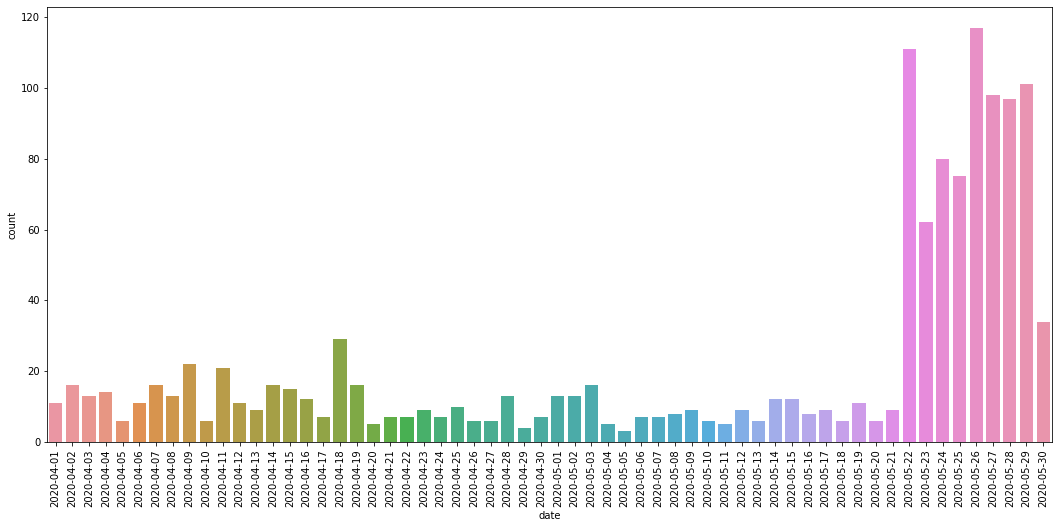

In [89]:
# plot the distribution of our new sample
fig = plt.figure(figsize = (18,8))
chart = sns.countplot(df['date'], order = sorted(df['date'].unique()))
chart.set_xticklabels(chart.get_xticklabels(), rotation = 90)

## Calculate users per day


In [90]:
# calculate users per day
user1 = pd.DataFrame(df.groupby('date')['User'].nunique())
user2 = pd.DataFrame(df.groupby('date')['Text'].nunique())
user = pd.concat([user1,user2],axis =1)
user['num_of_text_per_capita'] = user['Text']/user['User']
user['total_unique_user'] = unique_user
user['lag_user'] = lag_user
user['new_user'] = user['total_unique_user']-user['lag_user']
user.drop(['lag_user'],axis =1, inplace = True)
user.tail(10)

,User,Text,num_of_text_per_capita,total_unique_user,new_user
date,,,,,
2020-05-21,9,9,1.000000,2318,34
2020-05-22,107,111,1.037383,2365,47
2020-05-23,59,62,1.050847,3037,672
2020-05-24,78,80,1.025641,3339,302
2020-05-25,67,75,1.119403,3718,379
2020-05-26,112,117,1.044643,4055,337
2020-05-27,96,98,1.020833,4716,661
2020-05-28,91,97,1.065934,5214,498
2020-05-29,100,101,1.010000,5680,466


In [91]:
# ! jupyter kernelspec list

In [92]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from datetime import datetime

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

#word count
from collections import Counter

#word clouds
import heapq
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import collections
import matplotlib.cm as cm
from matplotlib import rcParams
from tqdm import tqdm

#sentiment analysis
from textblob import TextBlob

#text preprocessing
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('stopwords')
nltk.download('wordnet')

#hide warning
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\win\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\win\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [93]:
# Topic modeling
# spacy for lemmatization
import spacy;
# import en_core_web_sm
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# !pip install pyLDAvis
# Plotting tools
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [94]:
# read file
df = pd.read_csv("StayHome_final.csv")
# drop duplicate rows
df.drop_duplicates(inplace =True)
df.drop_duplicates(subset = ['Text'],inplace =True)
df.head()


,User,Text,Retweets,Favorites,HashTags,City,date,time
0,_Brian_McCarthy,TY @NYDailyNews @JWMason1 @nzewde: #COVID is t...,4,5,#COVID #Medicaid #ProtectMedicaid #NoMedicaidC...,New York,2020-05-27,15-07-05
1,ECSportsInvest,"#NHL is BACK,... Gary Bettman laid out the gro...",1,0,#NHL #COVID #sports,Boston,2020-05-29,19-00-34
2,SheSez,This week on the #SheSez #podcast: how to unta...,0,0,#SheSez #podcast #covid #travel,Los Angeles,2020-05-26,19-56-08
3,bhaukali_,It would be good if DOGS don't bark in the bat...,0,1,#not2all #laddakh #India #IndianArmy #COVID #b...,New York,2020-05-27,02-38-12
4,PreventionNYC,Research in neuroscience has proven that medit...,1,1,#ZoomInOnPrevention #NYCPOP #PartnersOfPrevent...,New York,2020-05-28,13-24-16


In [95]:
print('shape:', df.shape)
print('number of tweets:', df['Text'].nunique())
print('number of users:', df['User'].nunique())

print("range:", df['date'].min(),",", df['date'].max())
print("dates:",df['date'].nunique())

shape: (1300, 8)
number of tweets: 1300
number of users: 1121
range: 2020-04-01 , 2020-05-30
dates: 60


In [96]:
# get information about the number of missing values and their percentage
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
missing_values_table(df)

Your selected dataframe has 8 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


##  Number of Twits evenry day


Text(0.5, 1.0, 'Number of Tweets per day')

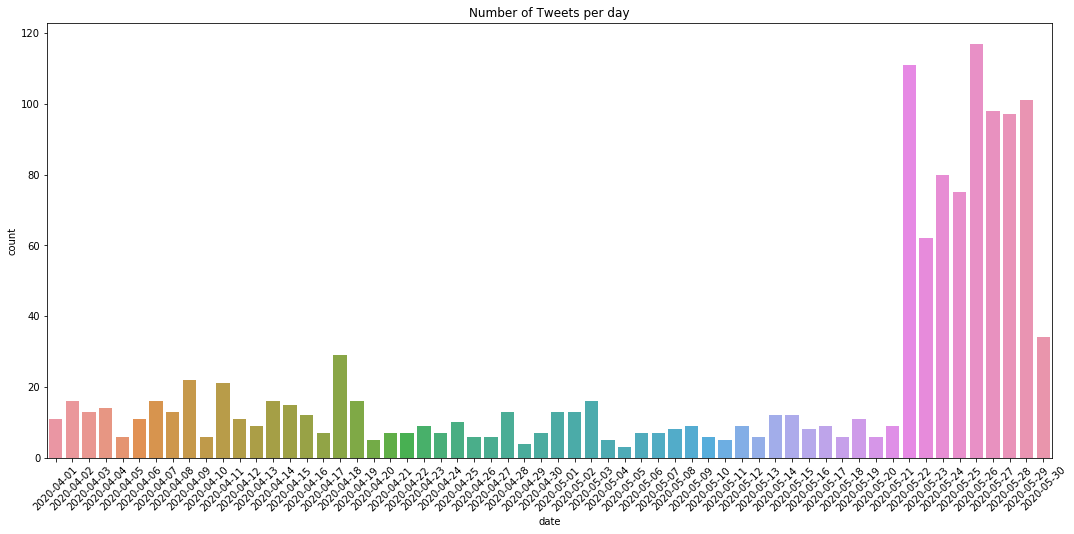

In [98]:

# plot number of tweets everyday
fig = plt.figure(figsize = (18,8))
chart = sns.countplot(df['date'], order = sorted(df['date'].unique()))
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart.set_title('Number of Tweets per day')

## Number of users per day

Text(0.5, 1.0, 'Number of Users per day')

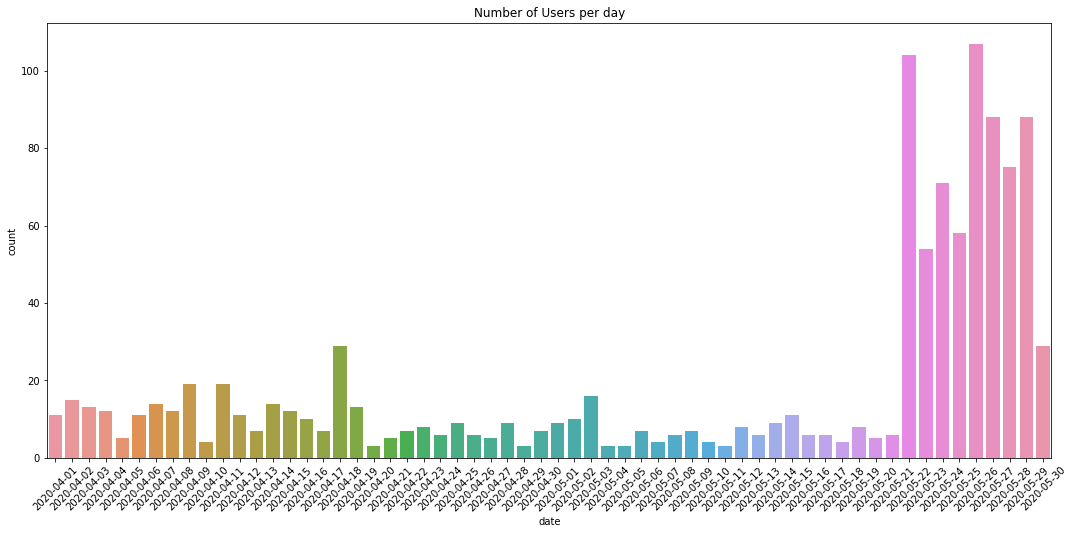

In [100]:
dates = sorted(df['date'].unique())
fig= plt.figure(figsize=(18,8))
chart = sns.countplot(df.groupby(['User'])['date'].min(), order = dates)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart.set_title('Number of Users per day')

## Number of Tweets Every day in Each Day

Text(0.5, 1.0, 'Number of Tweets in Different Cities Groups across Dates')

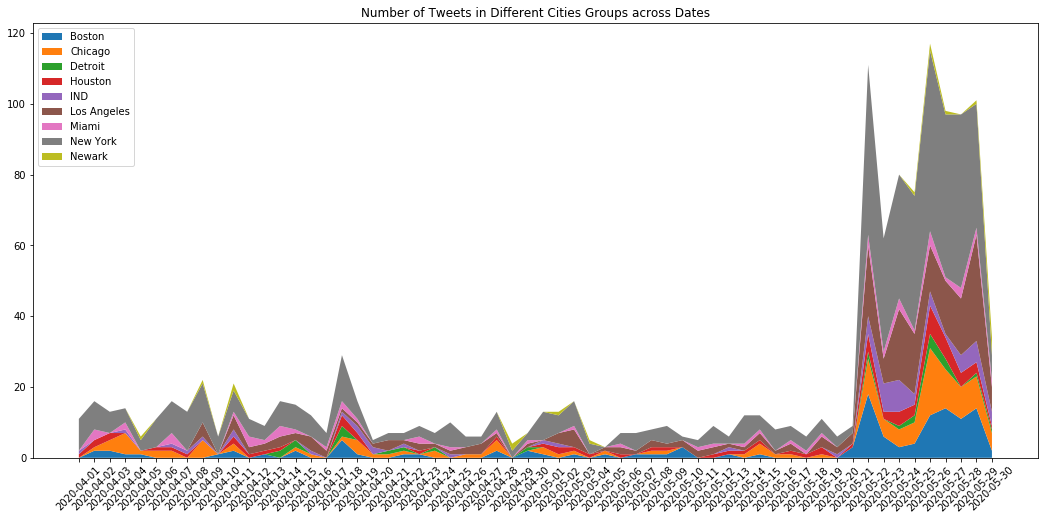

In [102]:
# plot number of tweets everyday in each city 
pivot = pd.pivot_table(df, index=['City'],
                         columns=['date'],
                         values=['Text'], 
                         aggfunc = lambda x: len(x), 
                         fill_value=0)

fig= plt.figure(figsize = (18,8))
plt.stackplot(sorted(df['date'].unique()), pivot.values, labels = pivot.index)
ax = plt.gca()
ax.set_xticks(sorted(df['date'].unique()))
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.title('Number of Tweets in Different Cities Groups across Dates')

In [103]:

# extract data that doesn't contain NAs only
df = df[df['HashTags'].notna()]
# since there's not a lot of twitter before 2020-03-13, we only need data after 2020-03-13
df = df[df['date']>'2020-03-13']

# Text  preprocessing

## Text before processing

In [104]:

# get rid of all kinds of strange symbols from text
def preprocess(Text):
    Text = Text.str.replace("(<br/>)", "")
    Text = Text.str.replace('(<a).*(>).*(</a>)', '')
    Text = Text.str.replace('(&amp)', '')
    Text = Text.str.replace('(&gt)', '')
    Text = Text.str.replace('(&lt)', '')
    Text = Text.str.replace('(\xa0…)', ' ')  
    Text = Text.str.replace('(\n)', ' ')
    Text = Text.str.replace('+', '')
    return Text

# remove urls from text
def remove_urls(row):
    url_pattern = re.compile(r"https?://\S+|www\.\S+")
    row =  url_pattern.sub(r'', row)
    return row

# remove @accounts (@[A-Za-z0–9]+)|, emojis，#hashtags, com frin text
def removes(row):
    url_pattern = re.compile(r"(\w+:\/\/\S+)|(#(\w+))|(.twitter.com/[A-Za-z0–9]+)")
    row =  url_pattern.sub(r'', row)
    return row
# apply all the preprocess functions
df['text_nlp'] = preprocess(df.Text)
df['text_nlp'] = df['text_nlp'].apply(remove_urls)
df['text_nlp'] = df['text_nlp'].apply(removes)

# text before preprocessing
df.Text[5]

'Calling attention to systemic structural racism, @RevDrBarber says "the virus has been like a contrast dye exposing what we should have cared about long before #COVID was our challenge." He\'s issuing "a call to care" to #Wes2020 grads in this @wesleyan_u commencement address.'

## Text after preprocessing


In [105]:

# text after preprocessing
df.text_nlp[5]

'Calling attention to systemic structural racism, @RevDrBarber says "the virus has been like a contrast dye exposing what we should have cared about long before  was our challenge." He\'s issuing "a call to care" to  grads in this @wesleyan_u commencement address.'

## Word_Count

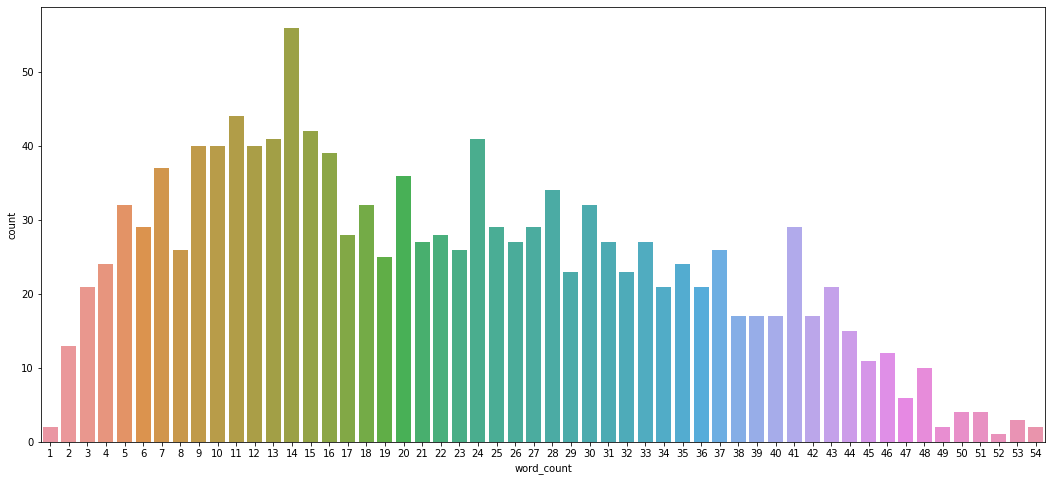

In [107]:
# Get the lenghth of text and word count
df['text_len'] = df.text_nlp.astype(str).apply(len)
df['word_count'] = df.text_nlp.apply(lambda x: len(str(x).split()))

fig= plt.figure(figsize = (18,8))
sns.countplot(df['word_count'])

In [108]:
# Handling Abbreviation
def decontracted(phrase):
    phrase = re.sub(r"that\'s", "that is", phrase)   
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# decontracte words
df.text_nlp = df.text_nlp.apply(lambda x: decontracted(x).lower())
# remove stop words
stop_words = stopwords.words('english')
not_stopwords = {}
common_words =['com','twitter','please',
               'the','would','could','can','may','must', 
              # 'us','i','you','this','we','me','that','it',
               'de','s','pic','t','m','en','la','que','don','re','e','el','ca']
stop_words.extend(word for word in common_words if word not in stop_words)
final_stop_words = set([word for word in stop_words if word not in not_stopwords])
df.text_nlp = df.text_nlp.apply(lambda x: ' '.join([word for word in x.split() if word not in final_stop_words]))

# remove whitespace and punctuations
rm_punc = re.compile(r"(\W)")
rm_space = re.compile(r"(\s+)")
df.text_nlp = df.text_nlp.apply(lambda x: rm_punc.sub(' ', x))
df.text_nlp = df.text_nlp.apply(lambda x: rm_space.sub(' ', x))

df.text_nlp[5]


'calling attention systemic structural racism revdrbarber says the virus like contrast dye exposing cared long challenge he s issuing a call care grads wesleyan_u commencement address '

# Sentiment Analysis

In [109]:
# get the polarity of each text
df['polarity'] = df.text_nlp.map(lambda text: TextBlob(text).sentiment.polarity)

# classify sentiment into positive and negative ones
df['sentiment'] = ''
df['sentiment'][df['polarity'] > 0] = 'positive'
df['sentiment'][df['polarity'] == 0] = 'neutral'
df['sentiment'][df['polarity'] < 0] = 'negative'

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Polarity

(0, 1000)

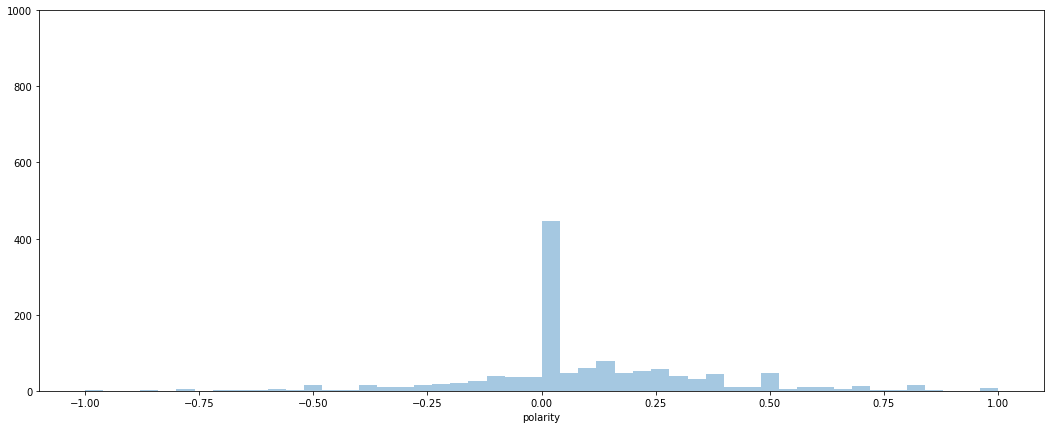

In [112]:
fig = plt.figure(figsize=(18,7))
sns.distplot(df['polarity'],kde = False)
plt.ylim(0, 1000)

## Sentiment

In [113]:
# Sentiment 
from IPython.core.display import display, HTML

x=df.groupby('sentiment').Text.count()

# displaying the total stats

display(HTML("<div style = 'background-color: #504e4e; padding: 30px '>" +
             "<span style='color: lightgreen; font-size:30px;'> Positive Tweets: "  + str(x['positive']) +"</span>" +
             "<span style='color: red; font-size:30px;margin-left:20px;'> Negative Tweets: " + str(x['negative']) + "</span>"+
             "<span style='color: #fff; font-size:30px; margin-left:20px;'> Neutral Tweets: " + str(x['neutral']) + "</span>"+
             "</div>")
       )

## Pie chart to show the ratio of 'Negative', 'Neutral' and 'Positive' tweets

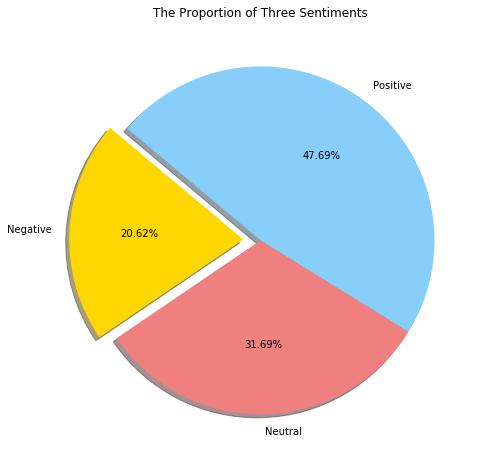

In [119]:
# draw a pie chart to show the ratio of 'Negative', 'Neutral' and 'Positive' tweets
fig = plt.figure(figsize=(8,8))
labels = 'Negative', 'Neutral', 'Positive'
sizes = df.groupby('sentiment').Text.count().values
colors = ['gold', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0) 

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.2f%%', shadow=True, startangle=140)
plt.title('The Proportion of Three Sentiments')
plt.show()

## Plot sentiment fluctuation with date

Text(0.5, 1.0, 'Average sentiment of Tweets across Dates')

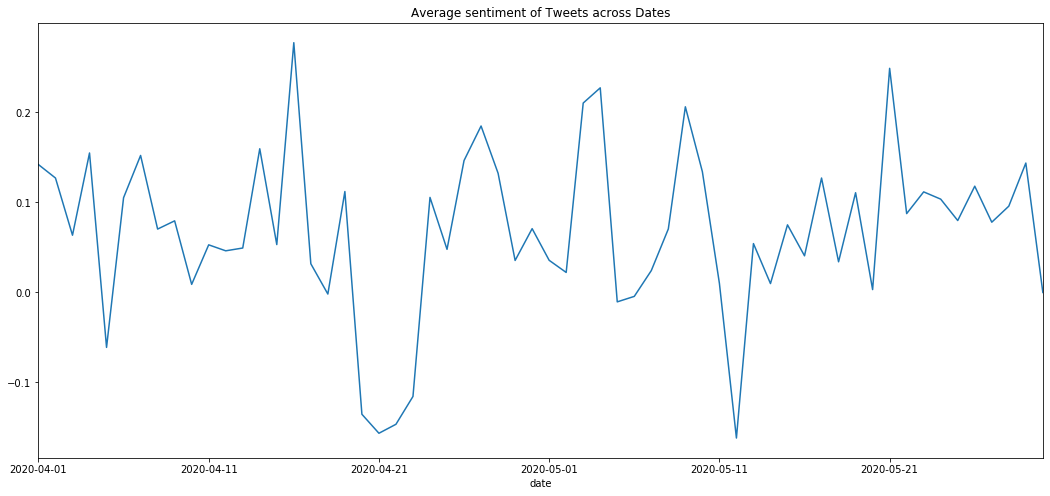

In [121]:
# plot sentiment fluctuation with date
fig, ax1 = plt.subplots(figsize=(18,8))
df.groupby(['date']).mean()['polarity'].plot(kind = 'line')
plt.title('Average sentiment of Tweets across Dates')

In [122]:
# Create word frequency count
num_words = 300
word2count = {}
for i in tqdm(range(len(df['text_nlp']))): 
    for word in df['text_nlp'].iloc[i].split():
        if word not in word2count.keys(): 
            word2count[word] = 1
        else: 
            word2count[word] += 1
            
freq_words = heapq.nlargest(num_words, word2count, key=word2count.get)

100%|███████████████████████████████████████████████████████████████████████████| 1300/1300 [00:00<00:00, 44868.83it/s]


In [123]:
from wordcloud import WordCloud, ImageColorGenerator
from os import path, getcwd
from PIL import Image
d = getcwd()
mask = np.array(Image.open(path.join(d,'twitter.png')).convert("RGB"))
color = np.array(Image.open(path.join(d,'color.png')).convert("RGB"))

def func(arr):   
    if(arr[2]==0):
        return np.array([255,255,255],dtype="uint8")
    else:
        return arr

mask=np.apply_along_axis(func, 2, mask)
color=np.apply_along_axis(func, 2, color)

## Word Clouds with Positive Polarity

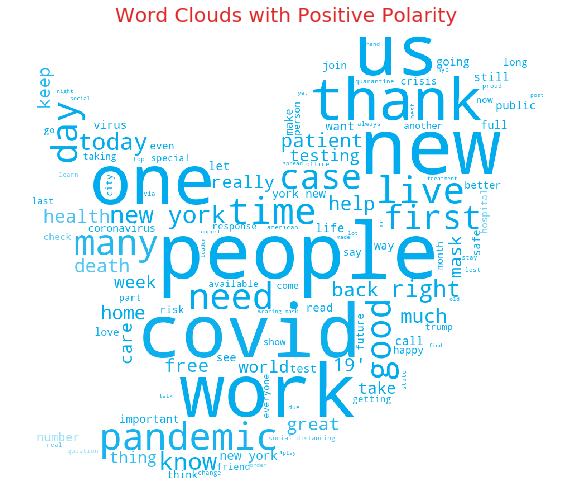

In [125]:
red = np.array(Image.open(path.join(d,'red.png')).convert("RGB"))
red=np.apply_along_axis(func, 2, red)

Image.fromarray(mask,"RGB")

wordcloud = WordCloud(width=1000, height=600, random_state=1, max_words=num_words, 
                          min_font_size=10,  max_font_size=140,
                          background_color='white',stopwords=set(STOPWORDS),mask = mask)
wordcloud.generate(str(set(df['text_nlp'][df['sentiment'] == 'positive'])))
    # declare our figure  
image_colors = ImageColorGenerator(color)
plt.figure(figsize=(10,10))
plt.title("Word Clouds with Positive Polarity", fontsize=20,color='#DE2929')
plt.imshow(wordcloud, interpolation='bilinear')
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='None')
plt.axis('off')
plt.show()


## Word Clouds with negative Polarity

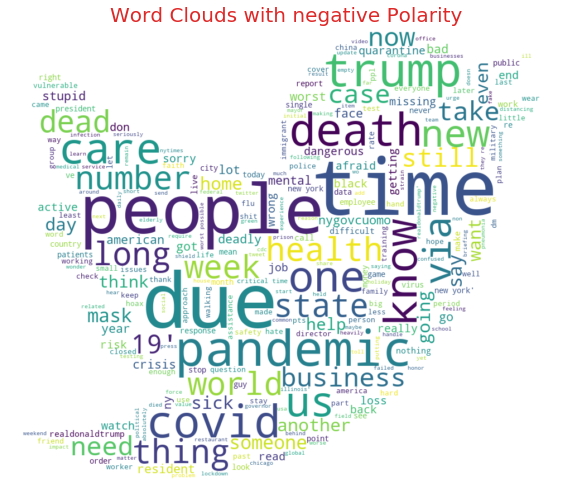

In [126]:
wordcloud = WordCloud(width=1000, height=500, random_state=1, max_words=num_words, 
                          min_font_size=10,  max_font_size=140,
                          background_color='white', stopwords=set(STOPWORDS),mask = mask)
wordcloud.generate(str(set(df['text_nlp'][df['sentiment'] == 'negative'])))
    # declare our figure  
image_colors = ImageColorGenerator(red)
plt.figure(figsize=(10,10))
plt.title("Word Clouds with negative Polarity", fontsize=20,color='#DE2929')
plt.imshow(wordcloud, interpolation='bilinear')
# plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='None')
plt.axis('off')
plt.show()

In [127]:
wordcloud.to_file('negative1.png')

## Symptoms:
> People may be sick with the virus for 1 to 14 days before developing symptoms. The most common symptoms of coronavirus disease (COVID-19) are fever, tiredness, and dry cough. Most people (about 80%) recover from the disease without needing special treatment.

1. Cough
2. Fever
3. Tiredness
4. Difficulty in breathing(severe cases)

